# Import Library

In [1296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns   
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Read Data

Menggunakan sep=';' untuk memisahkan data antar kolom yang dimana di csv itu pemisahannya menggunakan semicolon (;)

In [1297]:
df = pd.read_csv('HR_DATA.csv', sep=';')
df.head()

,RequestID,EmpID,EmpName,Dept,Request_Date,Completion_Date,Request_Detail,PIC
0,REQ0001,103,Charlie Davis,HR,01/01/2024,09/01/2024,Payroll Issue,Sarah Supervisor
1,REQ0002,103,Charlie Davis,HR,01/01/2024,02/01/2024,Access Approval,John Manager
2,REQ0003,105,Eve Wilson,HR,01/01/2024,03/01/2024,Access Approval,John Manager
3,REQ0004,104,David Brown,HR,02/01/2024,10/01/2024,Payroll Issue,Sarah Supervisor
4,REQ0005,102,Bob Smith,HR,02/01/2024,04/01/2024,Benefit Claim,John Manager


Cek tipe data tiap kolom
- Terdapat beberapa kolom yang tidak sesuai dengan tipe data nya

In [1298]:
df.dtypes

RequestID          object
EmpID               int64
EmpName            object
Dept               object
Request_Date       object
Completion_Date    object
Request_Detail     object
PIC                object
dtype: object

- Mengubah tipe data Completion Date dan Request Date menjadi datetime

In [1299]:
df['Completion_Date'] = pd.to_datetime(df['Completion_Date'], format='%d/%m/%Y')
df['Request_Date'] = pd.to_datetime(df['Request_Date'], format='%d/%m/%Y')

df.dtypes

RequestID                  object
EmpID                       int64
EmpName                    object
Dept                       object
Request_Date       datetime64[ns]
Completion_Date    datetime64[ns]
Request_Detail             object
PIC                        object
dtype: object

# 1. Feature Engineering

- Membuat inflow berdasarkan total request date
- Membuat outflow berdasarkan total completion date
- Membuat backlog berdasarkan total request date yang dimana completion datenya itu NULL
- Membuat open request berdasarkan request date yang dimana request datenya itu NULL

In [1300]:
inflow = df['Request_Date'].notna().sum()
outflow = df['Completion_Date'].notna().sum()
backlog = df[df['Request_Date'].notna() & df['Completion_Date'].isna()].shape[0]
open_req = df[df['Request_Date'].isna()].shape[0]

print(f'Inflow : {inflow}')
print(f'Outflow : {outflow}')
print(f'Backlog : {backlog}')
print(f'Open Request : {open_req}')

Inflow : 991
Outflow : 907
Backlog : 93
Open Request : 9


## 2. Observe and solve any missing value in categorical data.

Cek adakah kolom yang terdapat missing values dan insight yang didapat : 
- Terdapat kolom Request_Date (9), Completion_Date (93), Request_Detail (6) dan PIC (5) yang terdapat missing values

In [1301]:
df.isna().sum()

RequestID           0
EmpID               0
EmpName             0
Dept                0
Request_Date        9
Completion_Date    93
Request_Detail      6
PIC                 5
dtype: int64

- Mengisi missing values kolom kategorikal menggunakan modus karena modus merupakan nilai yang paling sering muncul, sehingga dianggap mewakili kategori yang paling umum tanpa menimbulkan bias besar pada data.

In [1302]:
df['Request_Detail'] = df['Request_Detail'].fillna(df['Request_Detail'].mode()[0])
df['PIC'] = df['PIC'].fillna(df['PIC'].mode()[0])

df.isna().sum()

RequestID           0
EmpID               0
EmpName             0
Dept                0
Request_Date        9
Completion_Date    93
Request_Detail      0
PIC                 0
dtype: int64

## 3. SLA compliance analysis

- Membuat kolom "Processing Days", yang dimana menghitung jumlah hari kerja yang dibutuhkan untuk menyelesaikan setiap permintaan : Processing Days = Completion Date − Request Date (excluding kecuali weekend atau holidays)

In [1303]:
df['Processing Days'] = df.apply(
    lambda row: np.busday_count(row['Request_Date'].date(), row['Completion_Date'].date())
    if pd.notna(row['Request_Date']) and pd.notna(row['Completion_Date'])
    else np.nan, axis=1
)

- Membuat kolom "SLA Compliance" kondisi : 
"Pass" jika Processing Days <= 3
"Miss" jika Processing Days > 3
"Pending" jika tidak memenuhi kriteria yang diatas (Kemungkinan Processing Days terdapat NULL)

In [1304]:
df['SLA Compliance'] = df['Processing Days'].apply(lambda x: 'Pass' if x <= 3 else 'Miss' if pd.notnull(x) else 'Pending')

## 4. Performance Insight

## Display Inflow, Outflow, Backlog dan Open Request

- Display Inflow, Outflow, Backlog dan Open Request using cards

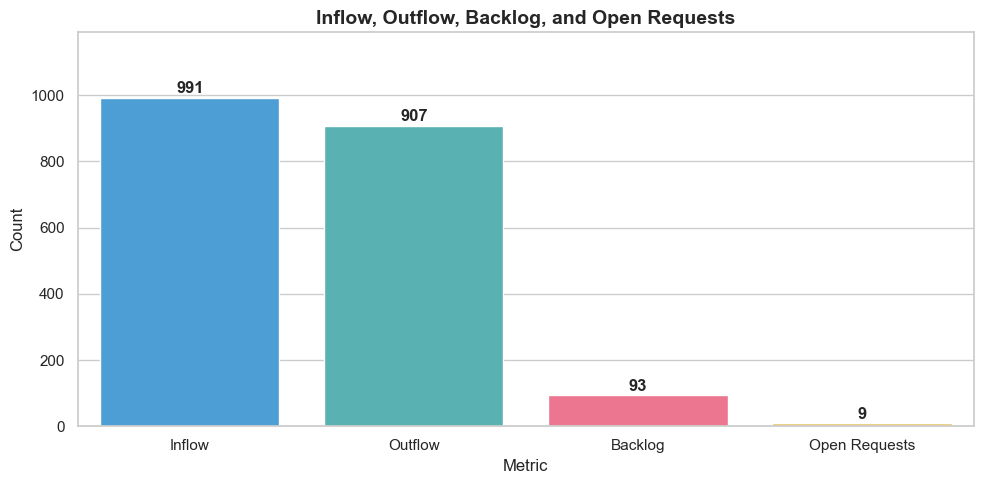

In [1305]:

result = pd.DataFrame({
    "Metric": ["Inflow", "Outflow", "Backlog", "Open Requests"],
    "Count": [inflow, outflow, backlog, open_req]
})


palette = ['#36A2EB', '#4BC0C0', '#FF6384', '#FFCE56']


plt.figure(figsize=(10, 5))


bars = sns.barplot(
    data=result, 
    x='Metric', 
    y='Count', 
    hue='Metric', 
    palette=palette,
    legend=False
)


for bar in bars.patches:
    height = bar.get_height()
    bars.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 5, 
        f'{int(height)}', 
        ha='center', 
        va='bottom', 
        fontsize=12, 
        weight='bold'
    )

plt.title('Inflow, Outflow, Backlog, and Open Requests', fontsize=14, weight='bold')
plt.ylim(0, max(result['Count']) * 1.2)
plt.tight_layout()
plt.show()


Insight yang didapat :
- Jumlah Inflow yang mencapai 991 ini menandakan permintaan yang sangat tinggi dari Employee
- Jumlah Outflow yang mencapai 907 ini menandakan permintaan yang telah diselesaikan PIC
- Jumlah Backlog yang mencapai 93 ini menandakan permintaan yang lagi dikerjakan PIC namun belum selesai
- Jumlah Open Requests mencapai 9 ini menandakan permintaan belum dikerjakan oleh PIC 

## Visualisasi Inflow vs Outflow per month

- Visualisasi Inflow vs. Outflow per bulan menggunakan line chart, bar chart, or mixed chart. Apa yang kamu amati? Apakah backlognya bertambah atau berkurang? Jika inflow > outflow, backlog bertambah. Jika outflow > inflow, PIC mengejar ketinggalan. Jika ada lonjakan musiman, beban kerja mungkin lebih tinggi pada bulan-bulan tertentu.
- Membuat kolom baru yaitu Request Month diambil dari Request Date yang diambil monthnya dan Completion Month diambil dari Completion Date yang diambil monthnya

In [1306]:
df['Request_Month'] = df['Request_Date'].dt.to_period('M')
df['Completion_Month'] = df['Completion_Date'].dt.to_period('M')

# Mengelompokkan data berdasarkan bulan dari kolom Request Month
inflow_monthly = df.groupby('Request_Month').size().rename('Inflow')

# Mengelompokkan data berdasarkan bulan dari kolom Completion Month
outflow_monthly = df.groupby('Completion_Month').size().rename('Outflow')

# Menggabungkan inflow_monthly dan outflow_monthly menjadi satu dataframe secara berdampingan
monthly = pd.concat([inflow_monthly, outflow_monthly], axis=1).fillna(0).astype(int)
# Mengubahnya menjadi format timestamp 
monthly.index = monthly.index.to_timestamp()

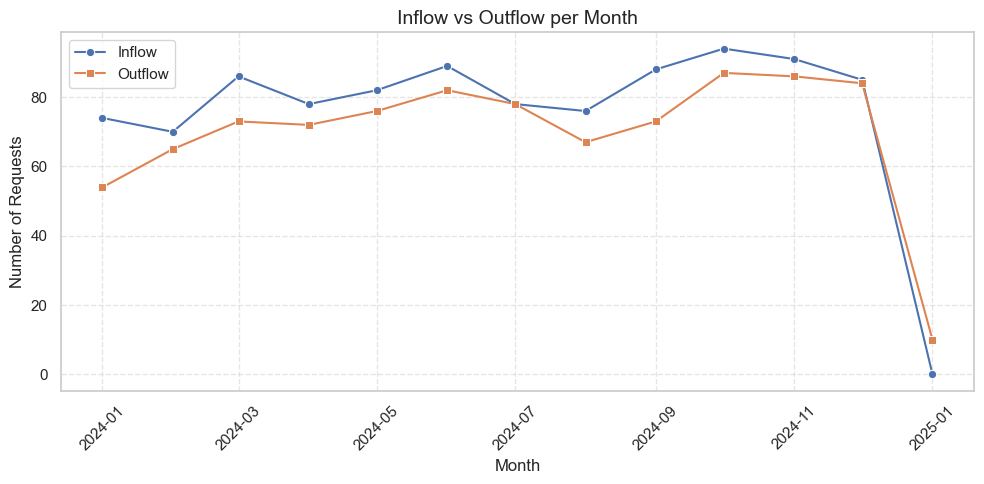

In [1307]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly, x=monthly.index, y='Inflow', label='Inflow', marker='o')
sns.lineplot(data=monthly, x=monthly.index, y='Outflow', label='Outflow', marker='s')

plt.title('Inflow vs Outflow per Month', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Requests')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Analyze the SLA Compliance trend per month

- Displaying the number of Pass vs. Miss cases over time.
- Membuat kolom baru yaitu SLA Compliance Month dari Completion Date yang diambil monthnya

In [1308]:
df['SLA Compliance Month'] = df['Completion_Date'].dt.to_period('M')

# Mengelompokkan SLA Compliance Month dan SLA Compliance 
sla_monthly = df.groupby(['SLA Compliance Month', 'SLA Compliance']).size().unstack(fill_value=0)
# Mengubah format menjadi timestamp
sla_monthly.index = sla_monthly.index.to_timestamp()

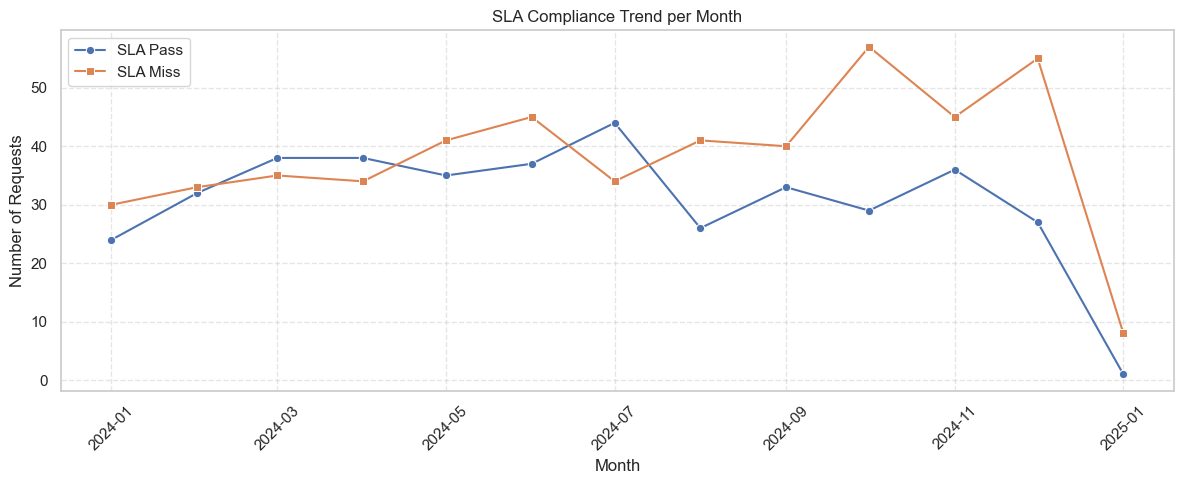

In [1309]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=sla_monthly['Pass'], label='SLA Pass', marker='o')
sns.lineplot(data=sla_monthly['Miss'], label='SLA Miss', marker='s')

plt.title('SLA Compliance Trend per Month')
plt.xlabel('Month')
plt.ylabel('Number of Requests')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Insight yang didapat : 
- Di beberapa bulan tertentu SLA miss diatas SLA Pass menandakan bahwa lebih banyak permintaan yang tidak terpenuhi 
- Performa terbaik terletak pada bulan Juli 2024 terlihat di atas grafik SLA Pass lebih tinggi daripada SLA Miss hal ini menunjukkan PIC telah menyelesaikan permintaan lebih dari miss
- Performa terburuk terletak pada bulan Oktober 2024 dan Desember 2024 yang terlihat di atas grafik SLA Miss lebih tinggi daripada SLA Pass hal ini menunjukkan PIC belum menyelesaikan banyak permintaan diluar 3 hari

# 6. Backlog Management

## - Display a table of backlog requests

Berdasarkan request tanpa completion date

In [1310]:
df_backlog = df[df['Request_Date'].notna() & df['Completion_Date'].isna()]
df_backlog

,RequestID,EmpID,EmpName,Dept,Request_Date,Completion_Date,Request_Detail,PIC,Processing Days,SLA Compliance,Request_Month,Completion_Month,SLA Compliance Month
5,REQ0006,105,Eve Wilson,HR,2024-01-03,NaT,Benefit Claim,John Manager,NaN,Pending,2024-01,NaT,NaT
23,REQ0024,102,Bob Smith,HR,2024-01-14,NaT,Access Approval,Michael Lead,NaN,Pending,2024-01,NaT,NaT
38,REQ0039,103,Charlie Davis,HR,2024-01-18,NaT,ID Card Replacement,John Manager,NaN,Pending,2024-01,NaT,NaT
57,REQ0058,102,Bob Smith,HR,2024-01-25,NaT,Access Approval,Michael Lead,NaN,Pending,2024-01,NaT,NaT
63,REQ0064,104,David Brown,HR,2024-01-27,NaT,Access Approval,John Manager,NaN,Pending,2024-01,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,REQ0984,101,Alice Johnson,HR,2024-12-24,NaT,ID Card Replacement,Sarah Supervisor,NaN,Pending,2024-12,NaT,NaT
989,REQ0990,102,Bob Smith,HR,2024-12-27,NaT,Payroll Issue,John Manager,NaN,Pending,2024-12,NaT,NaT
991,REQ0992,105,Eve Wilson,HR,2024-12-27,NaT,ID Card Replacement,Sarah Supervisor,NaN,Pending,2024-12,NaT,NaT
996,REQ0997,103,Charlie Davis,HR,2024-12-30,NaT,ID Card Replacement,Michael Lead,NaN,Pending,2024-12,NaT,NaT


- Memprediksi Completion Date untuk permintaan yang belum terselesaikan menggunakan machine learning atau metode statistik apa pun (rata-rata/median) untuk memperkirakan kapan permintaan tersebut kemungkinan besar akan diselesaikan --> menangani missing values

In [1311]:
# Membuat batas minimal model dapat memprediksi untuk menghindari tanggal out of bounds
base_date = df['Request_Date'].min()
# Membuat dataframe yang dimana hasil copy dari request date notnull dan completion date not null
complete_data = df[df['Request_Date'].notna() & df['Completion_Date'].notna()].copy()
# Membuat kolom baru Request_Days dan Completion_Days yang diambil dari dataframe complete data yang diubah menjadi hari
complete_data['Request_Days'] = (complete_data['Request_Date'] - base_date).dt.days
complete_data['Completion_Days'] = (complete_data['Completion_Date'] - base_date).dt.days
# Membuat kolom baru Processing days berdasarkan kolom Request Days - Completion Days
complete_data['Processing_Days'] = complete_data['Completion_Days'] - complete_data['Request_Days']

# Mengubah data kategorikal menjadi numerik agar bisa digunakan oleh algoritma Machine Learning untuk predict
X_c = pd.get_dummies(complete_data[['Request_Detail', 'PIC']], drop_first=True)
y_c = complete_data['Processing_Days']

# Splitting Data dibagi menjadi 80% untuk train banding 20% untuk test
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

# Beberapa Algoritma yang digunakan 
# Random Forest 
model_completion = RandomForestRegressor(n_estimators=100, random_state=42)
model_completion.fit(X_train, y_train)
# Decision Tree
# model_completion = DecisionTreeRegressor(random_state=42)
# model_completion.fit(X_train, y_train)
# model_completion.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [1312]:
# Melakukan one-hot encoding pada kolom kategorikal untuk data backlog
X_backlog = pd.get_dummies(df_backlog[['Request_Detail', 'PIC']], drop_first=True)
# Menyesuaikan kolom dengan data yang digunakan untuk training
X_backlog = X_backlog.reindex(columns=X_c.columns, fill_value=0)
# Menggunakan model yang sudah dilatih untuk prediksi jumlah hari sampai request selesai
predicted_days = model_completion.predict(X_backlog).round().astype(int)
# Membuat copy an data backlog yaitu pemintaan yang belum selesai
df_backlog = df[df['Completion_Date'].isna() & df['Request_Date'].notna()].copy()
# Menambahkan hasil predict ke tanggal selesai dan membuat kolom baru 
df_backlog.loc[:, 'Predicted_Completion_Date'] = df_backlog['Request_Date'] + pd.to_timedelta(predicted_days, unit='D')

- Memprediksi Request Start Date untuk permintaan yang Request Datenya NULL, memperkirakan kapan HR harus mulai memprosesnya.

In [1313]:
# Membuat dataframe yang dimana hasil copy dari request date not null dan completion date not null
df_pred = df[df['Request_Date'].notna() & df['Completion_Date'].notna()].copy()

# Membuat kolom baru Completion_Days yang diambil dari dataframe df_pred bagian completion_date dikurangi base date dan diubah menjadi hari
df_pred['Completion_Days'] = (df_pred['Completion_Date'] - base_date).dt.days
df_pred['Request_Days'] = (df_pred['Request_Date'] - base_date).dt.days

y_pred = df_pred['Request_Days']
# Mengubah data kategorikal menjadi numerik agar bisa digunakan oleh algoritma Machine Learning untuk predict
X_pred = pd.get_dummies(df_pred[['Completion_Days', 'Request_Detail', 'PIC']], drop_first=True)
# Splitting data menjadi 8:2
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pred, y_pred, test_size=0.2, random_state=42)

# Beberapa Algoritma yang digunakan
# Random Forest
model_request = RandomForestRegressor(n_estimators=100, random_state=42)
model_request.fit(X_train2, y_train2)
# Decision Tree
# model_request = DecisionTreeRegressor(random_state=42)
# model_request.fit(X_train2, y_train2)


RandomForestRegressor(random_state=42)

In [1314]:
# Membuat dataframe yang dimana hasil copy dari request date null dan completion date not null
df_open = df[df['Request_Date'].isna() & df['Completion_Date'].notna()].copy()
# Menghitung selisih completion date dan base date yang dikonversi menjadi hari dan di simpan menjadi kolom Completion Days
df_open['Completion_Days'] = (df_open['Completion_Date'] - base_date).dt.days
# Mengubah fitur kategorikal menjadi numerik (One-Hot Encoding) untuk Completion_Days, Request_Detail, dan PIC
X_open = pd.get_dummies(df_open[['Completion_Days', 'Request_Detail', 'PIC']], drop_first=True)
# Menyamakan kolom hasil encoding agar sesuai dengan model (X_pred), mengisi kolom yang hilang dengan 0
X_open = X_open.reindex(columns=X_pred.columns, fill_value=0)
# Melakukan prediksi Request_Date dalam bentuk hari sejak base_date menggunakan model_request
predicted_start_days = model_request.predict(X_open).round().astype(int)

# Menentukan batas minimum dan maksimum tanggal dari data asli (gabungan Request_Date dan Completion_Date)
min_date = pd.to_datetime(df[['Request_Date', 'Completion_Date']].min().min())
max_date = pd.to_datetime(df[['Request_Date', 'Completion_Date']].max().max())
# Menghitung selisih hari antara batas min/max tanggal dengan base_date
min_ordinal = (min_date - base_date).days
max_ordinal = (max_date - base_date).days

# Memastikan hasil prediksi tidak keluar dari batas min dan max yang telah ditentukan
predicted_start_days = np.clip(predicted_start_days, min_ordinal, max_ordinal)
# Mengonversi hasil prediksi (dalam bentuk jumlah hari sejak base_date) ke format datetime
df_open['Predicted_Request_Date'] = base_date + pd.to_timedelta(predicted_start_days, unit='D')

- Cek Mean Absolute Error dari model Machine Learning

In [1315]:
# Melakukan prediksi nilai Processing_Days (untuk Completion Date) dari data uji (X_test)
y_predC = model_completion.predict(X_test)
# Melakukan prediksi nilai Request_Days (untuk Request Date) dari data uji (X_test2)
y_predR = model_request.predict(X_test2)
# Menghitung Mean Absolute Error (MAE) antara nilai aktual dan prediksi untuk Completion Date
maeC = mean_absolute_error(y_test, y_predC)
# Menghitung Mean Absolute Error (MAE) antara nilai aktual dan prediksi untuk Request Date
maeR = mean_absolute_error(y_test2,y_predR)

print(f'MAE for Completion: {maeC} days')
print(f'MAE for Request : {maeR} days')

MAE for Completion: 2.534346171959644 days
MAE for Request : 3.110150462962963 days


# 7. PIC Performance Analysis

- Membuat a pie chart per PIC untuk memperlihatkan berapa banyak backlog requests yang mereka dapat, kategorikan berdasakan request details.

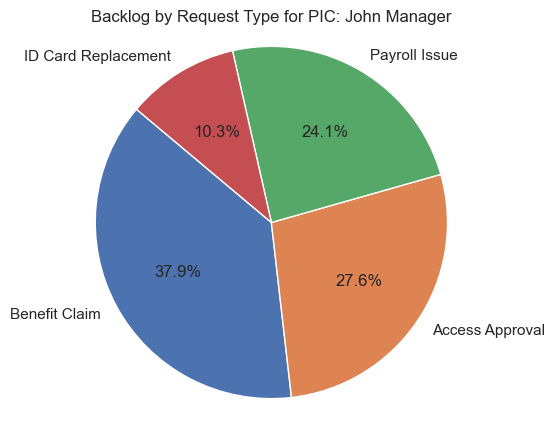

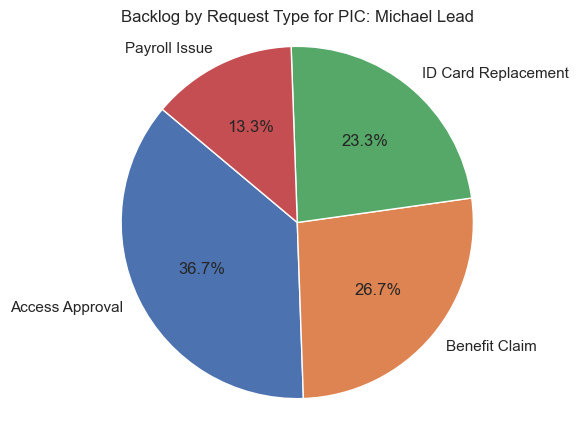

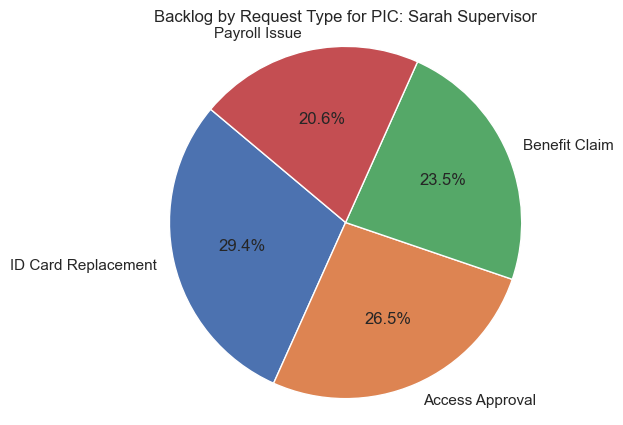

In [1316]:
for pic in df_backlog['PIC'].dropna().unique():
    df_pic = df_backlog[df_backlog['PIC'] == pic]
    if df_pic.empty: 
        continue
    counts = df_pic['Request_Detail'].value_counts()
    plt.figure(figsize=(5,5))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Backlog by Request Type for PIC: {pic}')
    plt.axis('equal')
    plt.show()


Insight yang didapat : 
- Untuk John terdapat permintaan benefit claim yang terbanyak dari total backlog ini menandakan bahwa permintaan ini paling sering diajukan ke John
- Untuk Michael terdapat permintaan Access Aproval yang terbanyak dari total backlog ini menunjukkan bahwa permintaan ini paling sering dijaukan ke Michael
- Untuk Sarah terlihat backlog yang merata antar kategori permintaan

# 8. Targeted Date Prediction Tables

- Tampilkan perkiraan completion date untuk permintaan yang belum terselesaikan dalam tabel terstruktur.
- Tampilkan perkiraan request start date di tabel lain untuk pelacakan yang lebih baik.

In [1317]:
# membuat variabel yang berisi kan dataframe df_backlog
pred_completion_table = df_backlog[['Request_Date', 'Request_Detail', 'PIC', 'Predicted_Completion_Date']].head(10)
# membuat variabel yang berisi kan dataframe df_open
pred_request_table = df_open[['Completion_Date', 'Request_Detail', 'PIC', 'Predicted_Request_Date']].head(10)
# Menampilkan kedua dataframe
display(pred_completion_table)
display(pred_request_table)

,Request_Date,Request_Detail,PIC,Predicted_Completion_Date
5,2024-01-03,Benefit Claim,John Manager,2024-01-08
23,2024-01-14,Access Approval,Michael Lead,2024-01-20
38,2024-01-18,ID Card Replacement,John Manager,2024-01-24
57,2024-01-25,Access Approval,Michael Lead,2024-01-31
63,2024-01-27,Access Approval,John Manager,2024-02-01
66,2024-01-29,Benefit Claim,John Manager,2024-02-03
67,2024-01-29,Benefit Claim,John Manager,2024-02-03
73,2024-01-31,Benefit Claim,Sarah Supervisor,2024-02-05
78,2024-02-02,Payroll Issue,Sarah Supervisor,2024-02-08
92,2024-02-08,Payroll Issue,Michael Lead,2024-02-13


,Completion_Date,Request_Detail,PIC,Predicted_Request_Date
785,2024-10-23,Benefit Claim,Michael Lead,2024-10-20
802,2024-11-03,Benefit Claim,Michael Lead,2024-10-29
821,2024-11-09,Payroll Issue,Michael Lead,2024-11-06
846,2024-11-13,ID Card Replacement,Sarah Supervisor,2024-11-04
869,2024-11-26,Payroll Issue,Sarah Supervisor,2024-11-20
896,2024-11-26,ID Card Replacement,Sarah Supervisor,2024-11-21
920,2024-12-05,Benefit Claim,John Manager,2024-11-27
953,2024-12-16,Access Approval,John Manager,2024-12-09
995,2025-01-09,Benefit Claim,Sarah Supervisor,2024-12-29


## End

In [1318]:
# Mengisi Missing Values tadi ke dalam dataframe utama
df.loc[df['Request_Date'].isna() & df['Completion_Date'].notna(), 'Request_Date'] = df_open['Predicted_Request_Date']
df.loc[df['Request_Date'].notna() & df['Completion_Date'].isna(), 'Completion_Date'] = df_backlog['Predicted_Completion_Date']

In [1319]:
# Update kolom yang terpengaruhi Request Date dan Completion Date
df['Processing Days'] = df.apply(
    lambda row: np.busday_count(row['Request_Date'].date(), row['Completion_Date'].date())
    if pd.notna(row['Request_Date']) and pd.notna(row['Completion_Date'])
    else np.nan, axis=1
)
df['SLA Compliance'] = df['Processing Days'].apply(lambda x: 'Pass' if x <= 3 else 'Miss' if pd.notnull(x) else 'Pending')
# Drop kolom yang tidak digunakan lagi pada dataframe utama
df = df.drop(['Request_Month', 'Completion_Month', 'SLA Compliance Month'], axis=1)


In [1320]:
df.isna().sum()

RequestID          0
EmpID              0
EmpName            0
Dept               0
Request_Date       0
Completion_Date    0
Request_Detail     0
PIC                0
Processing Days    0
SLA Compliance     0
dtype: int64

In [1321]:
df.to_csv('HR_DATA_Complete.csv', index=False)